In [13]:
#Authors: Akbota Assan (A69037121), Devana Perupurayil (A69034326), Melissa Medina-Peregrina (A59016508)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from scipy.stats import norm

In [14]:
detector_A = pd.read_csv('DetectorA.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_B = pd.read_csv('DetectorB.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_C = pd.read_csv('DetectorC.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_Target = pd.read_csv('DetectorTarget.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])

In [15]:
detector_A

,ID,cnn_score,Energy
0,371804.0,0.302,2614.488
1,594581.0,0.600,1705.200
2,1032837.0,0.481,1267.713
3,959143.0,0.154,2615.730
4,930779.0,0.093,1699.004
...,...,...,...
39995,440702.0,0.006,1465.075
39996,970685.0,0.018,1350.027
39997,226138.0,0.564,1126.152
39998,374147.0,0.587,1350.153


In [16]:
A_min_energy = detector_A["Energy"].min()
A_max_energy = detector_A["Energy"].max()
B_min_energy = detector_B["Energy"].min()
B_max_energy = detector_B["Energy"].max()
C_min_energy = detector_C["Energy"].min()
C_max_energy = detector_C["Energy"].max()
Target_min_energy = detector_Target["Energy"].min()
Target_max_energy = detector_Target["Energy"].max()

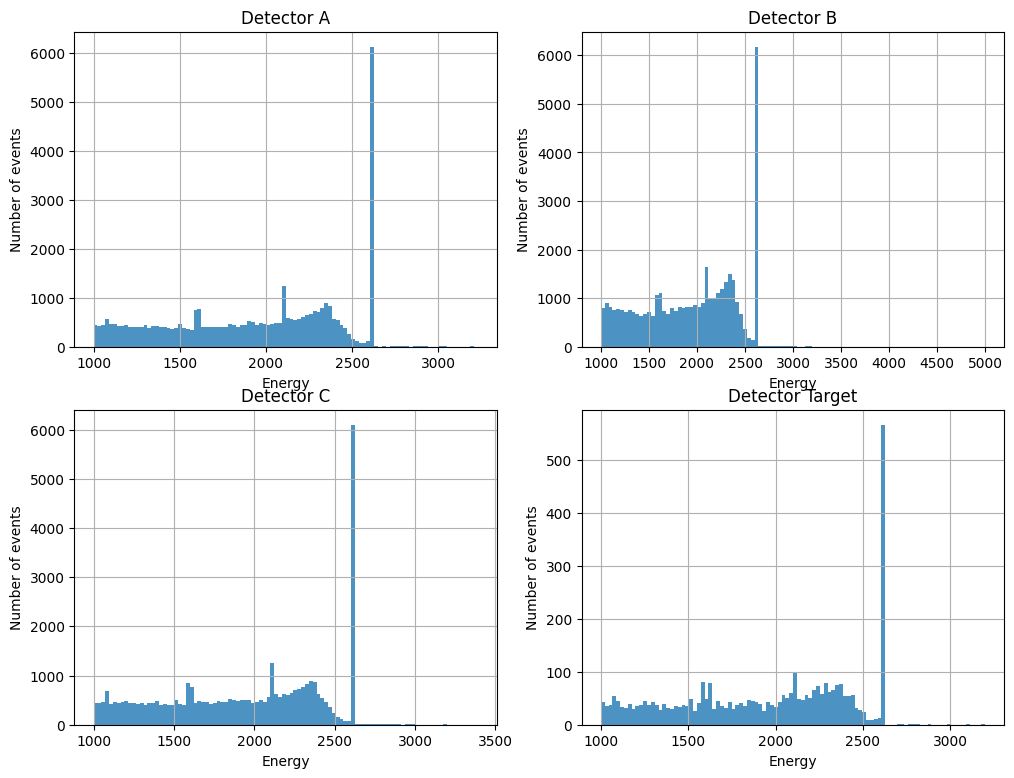

In [17]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.hist(detector_A["Energy"], bins=100, alpha=0.8, range=(A_min_energy, A_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detector_B["Energy"], bins=100, alpha=0.8, range=(B_min_energy, B_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detector_C["Energy"], bins=100, alpha=0.8, range=(C_min_energy, C_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(detector_Target["Energy"], bins=100, alpha=0.8, range=(Target_min_energy, Target_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target')
plt.grid(True)

0.7994350282485876


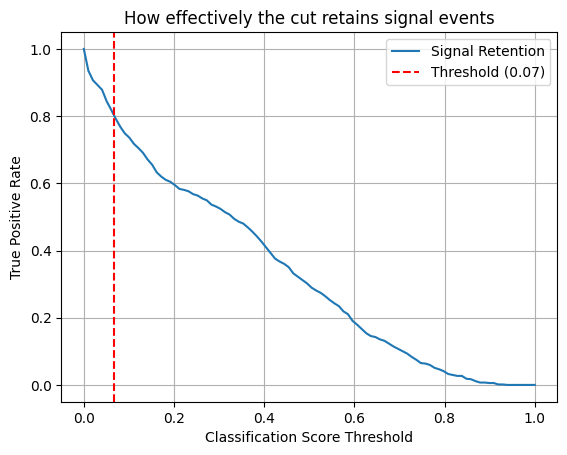

In [18]:
#Step 2

#Identify energy range around the 1592 keV peak
Peak_A = (detector_A["Energy"]>=1582)&(detector_A["Energy"]<=1602)
Peak_A_events = detector_A[Peak_A] 

#Take values with cnn_score above 90% as acceptable threshold
Threshold = np.percentile(Peak_A_events["cnn_score"], 20)
#print(Threshold)
Thresholds = np.linspace(0, 1, 100)

True_Positive = len(Peak_A_events[Peak_A_events["cnn_score"]>=Threshold])

False_Negative = len(Peak_A_events[Peak_A_events["cnn_score"]<Threshold])
#print(False_Negative)
Signal = True_Positive+False_Negative
True_Positive_Rate = True_Positive/Signal
print(True_Positive_Rate)
        
# Plot the signal retention as a function of threshold
plt.plot(Thresholds, [len(Peak_A_events[Peak_A_events["cnn_score"] >= t]) / len(Peak_A_events) for t in Thresholds], label="Signal Retention")
plt.axvline(Threshold, color='r', linestyle='--', label=f"Threshold ({Threshold:.2f})")
plt.xlabel("Classification Score Threshold")
plt.ylabel("True Positive Rate")
plt.title("How effectively the cut retains signal events")
plt.legend()
plt.grid()
plt.show()

0.36562763268744736


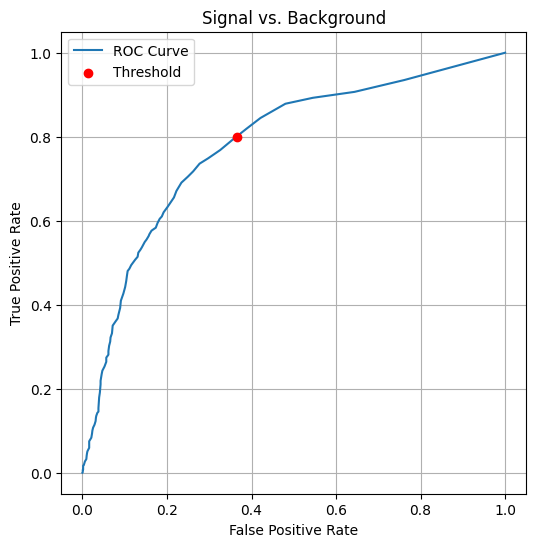

In [19]:
#Step 3

#Identify energy range around the 2103 keV peak
Peak_B = (detector_B["Energy"]>=2093)&(detector_B["Energy"]<=2113)
Peak_B_events = detector_B[Peak_B]

#Events in the 2103 keV region

False_positive = len(Peak_B_events[Peak_B_events["cnn_score"] >= Threshold])
True_Negative = len(Peak_B_events[Peak_B_events["cnn_score"]<Threshold]) 
Background = False_positive+True_Negative
False_Positive_Rate = False_positive/Background
print(False_Positive_Rate)

#Different thresholds
#thresholds = np.linspace(0, 1, 100)
TPR_values = [(Peak_A_events["cnn_score"] >= t).sum()/Signal for t in Thresholds]
FPR_values = [(Peak_B_events["cnn_score"] >= t).sum()/Background for t in Thresholds]

plt.figure(figsize=(6, 6))
plt.plot(FPR_values, TPR_values, label="ROC Curve")
plt.scatter(False_Positive_Rate, True_Positive_Rate, color="red", label="Threshold", zorder=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Signal vs. Background")
plt.legend()
plt.grid()
plt.show()

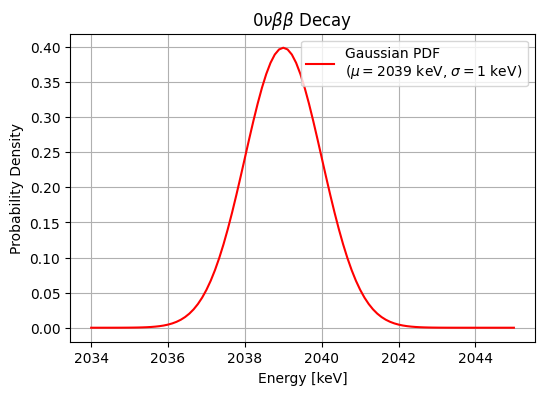

In [20]:
#Step 4

#Gaussian parameters sigma and peak energy
sigma = 1 
mu = 2039
E = np.linspace(2034, 2045, 100)

Gaussian_PDF = norm.pdf(E,mu,sigma)

plt.figure(figsize=(6, 4))
plt.plot(E, Gaussian_PDF, label=r'Gaussian PDF''\n''($\mu=2039$ keV, $\sigma=1$ keV)', color='r')
plt.legend(fontsize=8)
plt.xlabel("Energy [keV]")
plt.ylabel("Probability Density")
plt.title("$0\\nu\\beta\\beta$ Decay")
plt.legend()
plt.grid()
plt.show()